# Hindcast nitrate summary

For upwelling manuscript, Moore-Maley et al. in prep

***

In [1]:
import numpy as np
import xarray as xr
import os
from matplotlib import pyplot as plt, dates, patches, gridspec
from datetime import datetime, timedelta
from scipy import signal, fft
from tqdm.notebook import tqdm
from salishsea_tools import viz_tools

%matplotlib inline

In [2]:
plt.rcParams['font.size'] = 12

***

## Functions and definitions

In [3]:
def make_prefix(date, res='d', path='/results/SalishSea/nowcast-green.201812'):
    """Construct path prefix for local SalishSeaCast results given date object and paths dict
    e.g., /results/SalishSea/hindcast.201905/ddmmmyy/SalishSea_1d_yyyymmdd_yyyymmdd
    """

    datestr = '_'.join(np.repeat(date.strftime('%Y%m%d'), 2))
    prefix = os.path.join(path, date.strftime('%d%b%y').lower(), f'SalishSea_1{res}_{datestr}')
    
    return prefix

In [29]:
# Definitions
subdomain = [115, 360, 310, 788]
path = '/ocean/bmoorema/research/MEOPAR/analysis-ben-hg/data'
colors = ['powderblue', 'steelblue', 'orange', 'mistyrose', 'r']
y, x = [slice(*subdomain[slice(*pair)]) for pair in [(2, 4), (0, 2)]]
tmask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc').tmask[0, 0, ...]
stations = {
    'Discovery Passage': (730, 125),
    'Texada': (637, 175),
    'Central VI': (546, 174),
    'Boundary Pass': (370, 300),
    'CSOG': (500, 250),
}

cutoffs = {
    2015: [(4, 12), (8, 24)],
    2016: [(4,  7), (8, 22)],
    2017: [(4, 27), (9,  4)],
    2018: [(4,  5), (9,  2)],
    2019: [(4,  2), (9,  6)],
}

***

## Load data

Load time series

In [11]:
# Load results
data = {}
for key in ['raw', 'filtered']:
    data[key] = {'HRDPS': [], 'tau': []}
    for var in ['votemper', 'nitrate']:
        data[key][var] = {'mean': []}
        for station in stations: data[key][var][station] = []
window = signal.get_window('blackman', 73)
for year in tqdm(range(2015, 2020)):
    
    # Load HRDPS
    fn = f'{path}/GEM25/HRDPS_ops_{year}0101_{year}1231.nc'
    with xr.open_dataset(fn) as ds:
        
        # Meshmask cut off inlets and JdF+
        mask = ds.meshmask.values
        mask[:20, :20] = 0
        for lim in [(38, 48), (57, 30)]:
            mask[lim[0]:, lim[1]:] = 0
        mask = mask.reshape(-1).astype('bool')

        # Alongaxis wind
        u, v = [ds[var].values.reshape(-1, len(mask))[:, mask] for var in ['u_wind', 'v_wind']]
        jtau = np.sin(np.arctan2(v, u) - np.pi * (22 / 180))

        # Process and concatenate
        data['raw']['HRDPS'].append((jtau * np.sqrt(u**2 + v**2)).mean(axis=1))
        data['raw']['tau'].append((jtau * 1.22e-3 * (u**2 + v**2)).mean(axis=1))
    
    # Load SalishSeaCast
    fn = f'{path}/SalishSeaCast/SalishSea_1h_{year}0101_{year}1231_grid_T.nc'
    with xr.open_dataset(fn) as ds:
        
        # Get mean data
        mask = np.copy(tmask.values[y, x])
        mask[:90, :] = 0
        mask[400:, :] = 0
        mask[:, 190:] = 0
        mask[:160, :125] = 0
        mask[280:, 130:] = 0
        mask = mask.reshape(-1).astype('bool')
        for var in ['votemper', 'nitrate']:
            data['raw'][var]['mean'].append(ds[var].values.reshape(-1, len(mask))[:, mask].mean(axis=1))
        
        # Get data at each station
        for station in stations:
            j, i = [coord - subdomain[i] for coord, i in zip(stations[station], [2, 0])]
            for var in ['votemper', 'nitrate']:
                data['raw'][var][station].append(ds[var][:, j, i].values)

# Concatenate and filter
for var in ['HRDPS', 'tau']:
    data['raw'][var] = np.hstack(data['raw'][var])
    data['filtered'][var] = signal.convolve(data['raw'][var], window / sum(window), mode='same')
for var in ['votemper', 'nitrate']:
    for key in data['raw'][var]:
        data['raw'][var][key] = np.hstack(data['raw'][var][key])
        data['filtered'][var][key] = signal.convolve(data['raw'][var][key], window / sum(window), mode='same')

# Time array
data['time'] = np.array([datetime(2015, 1, 1) + timedelta(hours=h) for h in range(24*(365*5+1))])

Load profiles

In [14]:
# Build dict
variables = ['votemper', 'vosaline', 'nitrate', 'vert_eddy_diff']
filestrings = ['grid_T', 'grid_T', 'ptrc_T', 'grid_W']

profiles = {}
for var in variables:
    profiles[var] = {}
    for station in stations:
        profiles[var][station] = []

# Loop through year, variables and stations
for year in range(2015, 2019):
    start, end = [datetime(year, *md) for md in cutoffs[year]]
    for day in tqdm(range((end-start).days), f'Loading {year}'):
        for var, filestr in zip(variables, filestrings):
            depth = 'depthw' if filestr == 'grid_W' else 'deptht'
            with xr.open_dataset(f'{make_prefix(start + timedelta(day))}_{filestr}.nc') as ds:
                for station in stations:
                    y, x = stations[station]
                    profiles[var][station].append(ds[var].isel({depth: slice(0, 30), 'y': y, 'x': x}).values)

# Concatenate
for var in variables:
    for station in stations:
        profiles[var][station] = np.vstack(profiles[var][station])

$$T = \frac{h_0^2}{K_v} < 10^5 \text{ s}$$

$$K_v > \frac{h_0^2}{10^5} = 10^{-3}$$

In [26]:
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
deptht, depthw = [mask[key][0, :30].values for key in ('gdept_1d', 'gdepw_1d')]

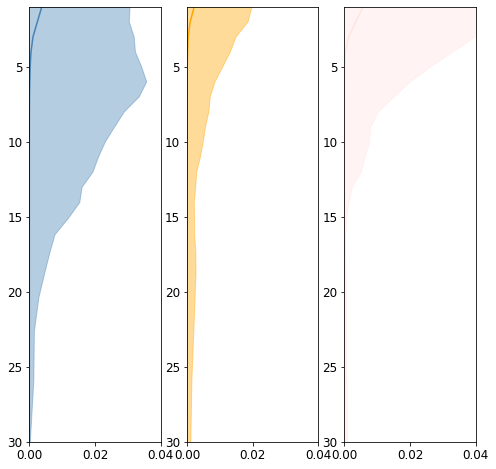

In [77]:
fig, axs = plt.subplots(1, 3, figsize=(8, 8))
var = 'vert_eddy_diff'

for ax, station, color in zip(axs, ['Texada', 'Central VI', 'CSOG'], colors[1:]):
    
    median = np.median(profiles[var][station][:, 1:], axis=0)
    q1, q2 = np.percentile(profiles[var][station][:, 1:], [1, 99], axis=0)
    
    ax.plot(median, depthw[1:], '-', color=color)
    ax.fill_betweenx(depthw[1:], q1, q2, facecolor=color, edgecolor=color, alpha=0.4)
    #ax.plot([3e-3, 3e-3], [0, 30], 'k--')
    ax.set_xlim([0, 0.04])
    ax.set_ylim([30, 1])

***

## Figures

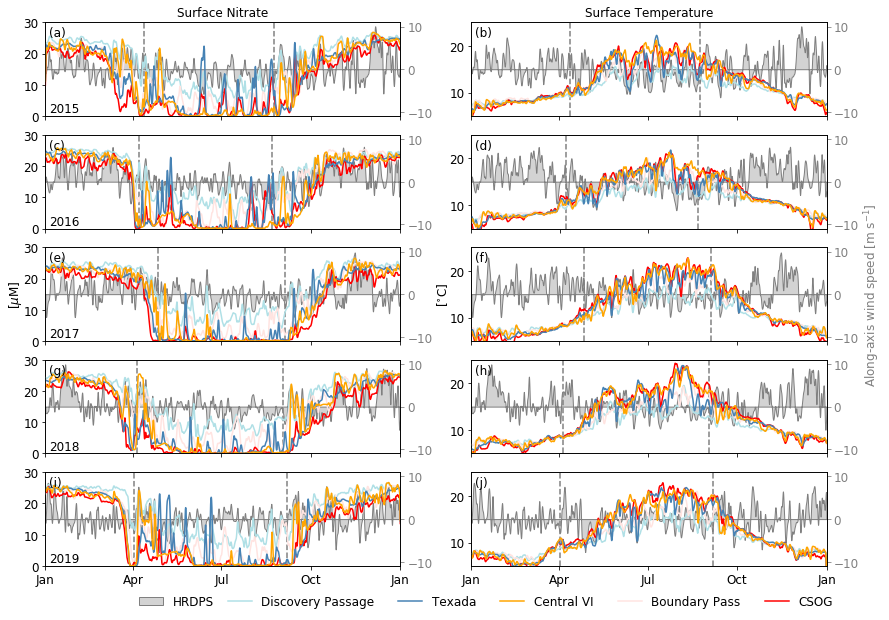

In [56]:
k = 0
fig, axs = plt.subplots(5, 2, figsize=(14, 10), gridspec_kw={'wspace': 0.2})
for row, year in zip(axs, range(2015, 2020)):
    
    row[0].text(0.01, 0.04, year, transform=row[0].transAxes)
    for ax, var, label, units, ylim in zip(
        row, ['nitrate', 'votemper'], ['Surface Nitrate', 'Surface Temperature'], ['[$\mu$M]', '[$^{\circ}$C]'], [(0, 30), (5, 25)]
    ):
        index = [abs(data['time'] - datetime(year+y, 1, 1)).argmin() for y in [0, 1]]
        xlim = [datetime(year, 1, 1), datetime(year+1, 1, 1)]
        
        # Set up axes
        ax.set_zorder(1)
        ax.patch.set_visible(False)
        ax2 = ax.twinx()
        ax2.set_ylim([-11, 11])
        ax.set_ylim(ylim)
        ax.set_xlim(xlim)
        ax2.tick_params(axis='y', colors='gray')
        if year == 2017:
            ax.set_ylabel(units, labelpad=-1)
            if var == 'votemper': ax2.set_ylabel('Along-axis wind speed [m s$^{-1}$]', color='gray')
        
        ax2.fill_between(data['time'][slice(*index)], data['filtered']['HRDPS'][slice(*index)], facecolor='lightgray', edgecolor='gray', label='HRDPS')
        for station, color, zorder in zip(stations, colors, [1, 2, 2, 1, 1]):
            ax.plot(data['time'][slice(*index)], data['filtered'][var][station][slice(*index)], color=color, label=station, zorder=zorder)
        for cutoff in cutoffs[year]: ax2.plot(np.repeat(datetime(year, *cutoff), 2), [-11, 11], 'k--', color='gray')
        ax.xaxis.set_major_locator(dates.MonthLocator(interval=3))
        ax.xaxis.set_major_formatter(dates.DateFormatter('%b'))
        if year < 2019: ax.xaxis.set_ticklabels('')
        if year == 2015: ax.set_title(f'{label}', fontsize=12)
        ax.text(0.01, 0.85, f'({chr(97+k)})', transform=ax.transAxes)
        k += 1
ax.legend(loc=(-0.7, -0.5), ncol=5, frameon=False)
ax2.legend(loc=(-0.95, -0.5), frameon=False)

#fig.savefig('/home/bmoorema/Desktop/timeseries.pdf', bbox_inches='tight')

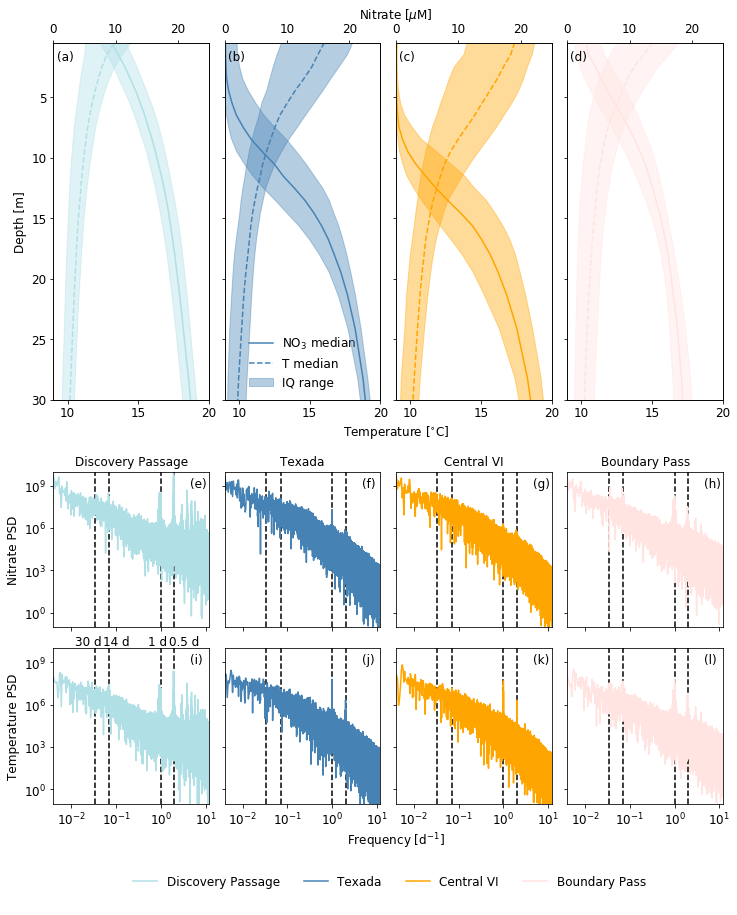

In [217]:
# Plot surface nitrate PSD at coastal stations
fig = plt.figure(figsize=(12, 14))
gs = gridspec.GridSpec(4, 4, hspace=0.3, wspace=0.1)
xlim, ylim, n = [4e-3, 12], [1e-1, 1e10], len(data['time'])
freq = np.linspace(0, 12, 50001)
k = 0
for col, station, color in zip(range(4), stations, colors):
    ax = fig.add_subplot(gs[:2, col])
    ax.set_xlim([9, 20])
    ax.set_ylim([30, 0.5])
    ax2 = ax.twiny()
    ax2.set_xlim([0, 25])
    ax2.text(0.02, 0.95, f'({chr(97+k)})', transform=ax.transAxes)
    k += 1
    if col == 0: ax.set_ylabel('Depth [m]')
    else: ax.yaxis.set_ticklabels('')
    if col == 1:
        ax2.set_xlabel('Nitrate [$\mu$M]', x=1.1)
        ax.set_xlabel('Temperature [$^{\circ}$C]', x=1.1)
    l = []
    for axplot, var, ls in zip([ax2, ax], ['nitrate', 'votemper'], ['-', '--']):
        median = np.median(profiles[var][station], axis=0)
        q1, q2 = np.percentile(profiles[var][station], [25, 75], axis=0)
        p, = axplot.plot(median, deptht, ls, color=color)
        l.append(p)
        p = axplot.fill_betweenx(deptht, q1, q2, facecolor=color, edgecolor=color, alpha=0.4)
        l.append(p)
    del l[1]
    if col == 1: ax.legend(l, ['NO$_3$ median', 'T median', 'IQ range'], loc=8, frameon=False)

l = []
for row, var, label in zip(range(2, 4), ['nitrate', 'votemper'], ['Nitrate', 'Temperature']):
    for col, station, color, xpos in zip(range(4), stations, colors, [0.1, 0.2, 0.3, 0.4]):
        ax = fig.add_subplot(gs[row, col])
        for day, x in zip([0.5, 1, 14, 30], [0.74, 0.61, 0.32, 0.14]):
            ax.plot([1/day, 1/day], ylim, 'k--')
            if (row == 3) and (col == 0): ax.text(x, 1.02, f'{day} d', transform=ax.transAxes)
        PSD = abs(fft.rfft(data['raw'][var][station], n=100000))**2
        p, = ax.plot(freq, PSD, '-', color=color, label=station)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.xaxis.set_ticks([1e-2, 1e-1, 1, 10])
        ax.yaxis.set_ticks([1, 1e3, 1e6, 1e9])
        if row == 2:
            pos = ax.get_position()
            ax.set_position([pos.x0, pos.y0-0.025, pos.width, pos.height])
            ax.set_title(station, fontsize=12)
            ax.xaxis.set_ticklabels('')
            l.append(p)
        else:
            if col == 1: ax.set_xlabel('Frequency [d$^{-1}$]', x=1.1)
        if col == 0: ax.set_ylabel(f'{label} PSD')
        else: ax.yaxis.set_ticklabels('')
        ax.text(0.88, 0.9, f'({chr(97+k)})', transform=ax.transAxes)
        k += 1
        
fig.legend(l, stations.keys(), ncol=4, bbox_to_anchor=(0.76, 0.05), frameon=False)
fig.savefig('/home/bmoorema/Desktop/spectra_profiles.pdf', bbox_inches='tight')

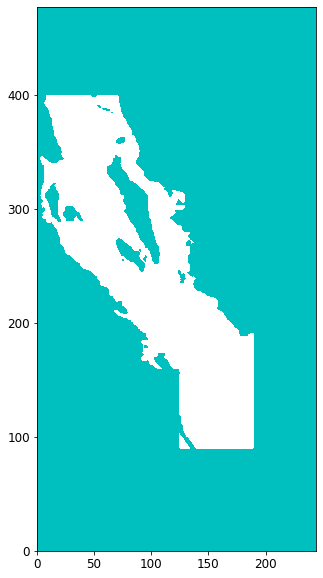

In [32]:
mask = np.copy(tmask.values[y, x])
mask[:90, :] = 0
mask[400:, :] = 0
mask[:, 190:] = 0
mask[:160, :125] = 0
mask[280:, 130:] = 0

fig, ax = plt.subplots(figsize=(5, 10))
ax.contourf(mask, levels=[-0.01, 0.01], colors='c')

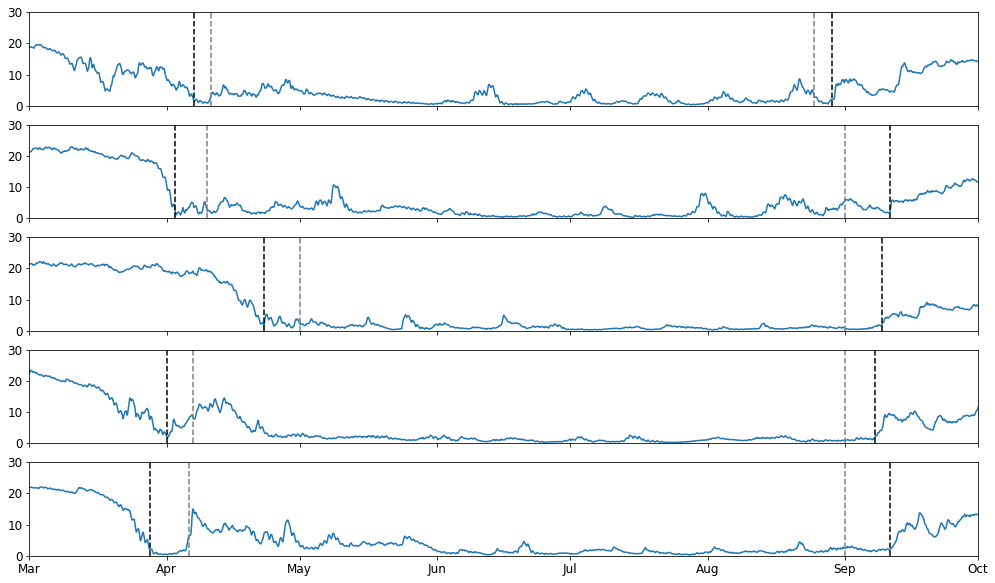

In [72]:
fig, axs = plt.subplots(5, 1, figsize=(17, 10))

for ax, year in zip(axs, range(2015, 2020)):
    index = [abs(data['time'] - datetime(year+yr, 1, 1)).argmin() for yr in [0, 1]]
    x, y = data['time'][slice(*index)], data['raw']['nitrate']['mean'][slice(*index)]
    iblooms = np.where(y < 2)[0][[0, -1]]
    ax.plot(x, y, '-')
    for cutoff in iblooms: ax.plot(np.repeat(x[cutoff], 2), [0, 30], 'k--')
    ax.set_xlim(datetime(year, 3, 1), datetime(year, 10, 1))
    ax.set_ylim([0, 30])
    ax.xaxis.set_major_locator(dates.MonthLocator())
    ax.xaxis.set_major_formatter(dates.DateFormatter('%b'))
    if year < 2019: ax.xaxis.set_ticklabels('')